In [1]:


import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
%matplotlib inline

In [3]:
ticker = "SPY"  # SPDR S&P 500 ETF
data = yf.Ticker(ticker)

In [4]:
historical_data = data.history(period="6mo")
print("Historical Stock Data Sample:")
print(historical_data.head())

Historical Stock Data Sample:
                                 Open        High         Low       Close  \
Date                                                                        
2024-06-28 00:00:00-04:00  543.657082  546.757163  539.474073  540.735901   
2024-07-01 00:00:00-04:00  542.136876  542.385276  539.046801  541.848755   
2024-07-02 00:00:00-04:00  540.219297  545.495300  540.169629  545.495300   
2024-07-03 00:00:00-04:00  545.177280  548.297192  545.137558  547.929565   
2024-07-05 00:00:00-04:00  548.237551  551.496521  547.591688  551.089172   

                             Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                         
2024-06-28 00:00:00-04:00  76144500        0.0           0.0            0.0  
2024-07-01 00:00:00-04:00  40297800        0.0           0.0            0.0  
2024-07-02 00:00:00-04:00  40434800        0.0           0.0            0.0  
2024-07-03 00:00:00-04:00  32789900     

In [5]:
expiry_dates = data.options  # Available expiration dates
print("Available Expiry Dates:", expiry_dates)

Available Expiry Dates: ('2024-12-30', '2024-12-31', '2025-01-02', '2025-01-03', '2025-01-10', '2025-01-17', '2025-01-24', '2025-01-31', '2025-02-21', '2025-02-28', '2025-03-21', '2025-03-31', '2025-04-17', '2025-04-30', '2025-05-16', '2025-05-30', '2025-06-20', '2025-06-30', '2025-07-18', '2025-08-15', '2025-09-19', '2025-09-30', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15')


In [6]:
chosen_expiry = expiry_dates[0]
option_chain = data.option_chain(chosen_expiry)

In [7]:
calls = option_chain.calls
puts = option_chain.puts
print("Sample Call Options:")
print(calls.head())
print("Sample Put Options:")
print(puts.head())

Sample Call Options:
       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  SPY241230C00410000 2024-12-20 14:59:23+00:00   410.0     172.81  184.56   
1  SPY241230C00510000 2024-12-27 21:10:21+00:00   510.0      85.13   84.58   
2  SPY241230C00515000 2024-12-20 15:10:40+00:00   515.0      68.32   79.58   
3  SPY241230C00525000 2024-12-27 21:10:57+00:00   525.0      70.12   69.58   
4  SPY241230C00530000 2024-12-27 19:57:44+00:00   530.0      65.39   64.58   

      ask     change  percentChange  volume  openInterest  impliedVolatility  \
0  185.79   0.000000       0.000000     2.0             1           1.664064   
1   85.81  11.829994      16.139145     2.0            10           0.770510   
2   80.81   0.000000       0.000000    10.0            10           0.727542   
3   70.80  12.300003      21.272923     2.0             2           0.640629   
4   65.81  11.250000      20.779460     1.0             1           0.600590   

   inTheMoney contractSize cu

In [8]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Black-Scholes formula for option pricing.
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    T (float): Time to maturity in years
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying stock
    option_type (str): "call" or "put"
    
    Returns:
    float: Option price
    """
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Step 4: Calculate Option Greeks
def calculate_greeks(S, K, T, r, sigma):
    """
    Calculate the Greeks: Delta, Gamma, Vega, Theta, Rho.
    
    Parameters:
    S, K, T, r, sigma: Same as in Black-Scholes
    
    Returns:
    dict: Greeks values
    """
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = norm.cdf(d1) if option_type == "call" else -norm.cdf(-d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) -
             r * K * np.exp(-r * T) * norm.cdf(d2 if option_type == "call" else -d2))
    rho = (K * T * np.exp(-r * T) *
           (norm.cdf(d2) if option_type == "call" else -norm.cdf(-d2)))
    
    return {"Delta": delta, "Gamma": gamma, "Vega": vega, "Theta": theta, "Rho": rho}


In [10]:
def compare_prices(options, S, r, T, sigma, option_type):
    """
    Compare actual and theoretical prices for options.
    
    Parameters:
    options (DataFrame): Option chain (calls or puts)
    S (float): Current stock price
    r (float): Risk-free rate
    T (float): Time to maturity
    sigma (float): Volatility
    option_type (str): "call" or "put"
    
    Returns:
    DataFrame: DataFrame with actual and theoretical prices
    """
    results = []
    for index, row in options.iterrows():
        K = row["strike"]
        actual_price = row["lastPrice"]
        theoretical_price = black_scholes(S, K, T, r, sigma, option_type)
        results.append({
            "Strike": K,
            "Actual Price": actual_price,
            "Theoretical Price": theoretical_price
        })
    return pd.DataFrame(results)


In [15]:
# Parameters
S = historical_data["Close"].iloc[-1]  # Current stock price (last closing price)
r = 0.03  # Approximate risk-free rate (3%)
T = (pd.to_datetime(chosen_expiry) - dt.datetime.now()).days / 365  # Time to maturity in years
sigma = 0.2  # Approximate volatility (can be adjusted or calculated)

# Ensure these variables print correctly
print(f"Stock Price (S): {S}")
print(f"Risk-Free Rate (r): {r}")
print(f"Time to Maturity (T): {T} years")
print(f"Volatility (σ): {sigma}")

# Compare call and put option prices
call_prices = compare_prices(calls, S, r, T, sigma, option_type="call")
put_prices = compare_prices(puts, S, r, T, sigma, option_type="put")

print("Comparison for Calls:")
print(call_prices.head())
print("Comparison for Puts:")
print(put_prices.head())


Stock Price (S): 595.010009765625
Risk-Free Rate (r): 0.03
Time to Maturity (T): 0.0027397260273972603 years
Volatility (σ): 0.2
Comparison for Calls:
   Strike  Actual Price  Theoretical Price
0   410.0        172.81         185.043707
1   510.0         85.13          85.051926
2   515.0         68.32          80.052337
3   525.0         70.12          70.053159
4   530.0         65.39          65.053570
Comparison for Puts:
   Strike  Actual Price  Theoretical Price
0   430.0          0.01      1.613708e-212
1   440.0          0.01      6.717342e-184
2   460.0          0.01      1.735265e-134
3   470.0          0.01      2.205226e-113
4   480.0          0.01       1.716540e-94


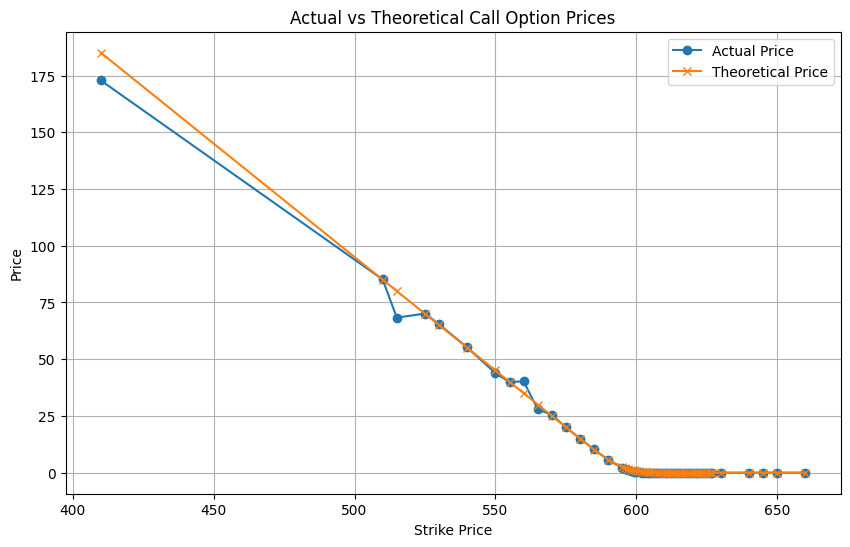

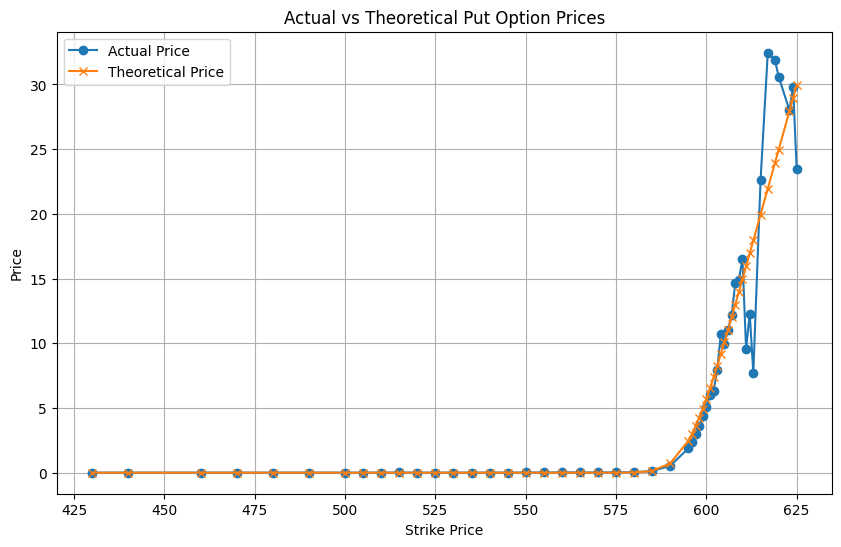

In [16]:
# Plotting Function
def plot_prices(comparison_df, option_type):
    """
    Plot actual vs. theoretical prices.
    
    Parameters:
    comparison_df (DataFrame): DataFrame with comparison data
    option_type (str): "call" or "put"
    """
    plt.figure(figsize=(10, 6))
    plt.plot(comparison_df["Strike"], comparison_df["Actual Price"], label="Actual Price", marker="o")
    plt.plot(comparison_df["Strike"], comparison_df["Theoretical Price"], label="Theoretical Price", marker="x")
    plt.title(f"Actual vs Theoretical {option_type.capitalize()} Option Prices")
    plt.xlabel("Strike Price")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Ensure call_prices and put_prices exist before plotting
if "call_prices" in locals() and not call_prices.empty:
    plot_prices(call_prices, "call")
else:
    print("Error: `call_prices` is not defined or empty.")

if "put_prices" in locals() and not put_prices.empty:
    plot_prices(put_prices, "put")
else:
    print("Error: `put_prices` is not defined or empty.")
